In [1]:
%matplotlib inline
from __future__ import unicode_literals
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.rc('font',family='serif')

In [2]:
# Patek and Klomfar, my implementation
import libr_props
myH = np.vectorize(libr_props.massSpecificEnthalpy)

# Patek and Klomfar spline fit but incorrect reference states
import CoolProp.CoolProp as CP
librname = lambda(x): 'INCOMP::LiBr[{}]'.format(x)
def Hsat1(T,x):
    try:
        h = CP.PropsSI('H','T',T,'Q',0,librname(x))
        return h
    except:
        return np.nan
Hsat2 = np.vectorize(Hsat1)
def Hsat3(P,x):
    try:
        #perr = lambda(t): CP.PropsSI('P','T',t,'Q',0,librname(x))-P
        #t = fsolve(perr,360)[0]
        #h = CP.PropsSI('H','T',t,'Q',0,librname(x))
        t = libr_props.temperature(P*1e-5,x)
        h = libr_props.massSpecificEnthalpy(t,x)
        return h
    except:
        return np.nan
Hsat4 = np.vectorize(Hsat3)

# According to EES, this is from ASHRAE Fundamentals 1998.
# It is also printed in ASHRAE fundamentals 2013, chapter 30, figure 34.
# The formula is a quadratic in T and quartic in X.
from ees_interface2 import EES_DLL
LiBr_path = 'C:/EES32/Userlib/Libr/LIBR.dll'
myDLL = EES_DLL(LiBr_path)
h_libr=myDLL.func['H_LIBR']
def hfun(T,x):
    inarglist=[T-273.15,x*100.,2]
    s0,outarglist=h_libr.call("",inarglist)
    return outarglist * 1e3
hfun2=np.vectorize(hfun)

# EES has also added recently some more stuff.
LiBrSSC_path = 'C:/EES32/Userlib/Libr/SSCLiBr.dll'
SSC_DLL = EES_DLL(LiBrSSC_path)
h_librssc=SSC_DLL.func['LiBrSSCh']
def hfun3(T,x,P=None):
    if P==None:
        s0,outarglist=h_librssc.call("",[T-273.15,x])
    else:
        s0,outarglist=h_librssc.call("",[T-273.15,x,P*1e-3])
    return outarglist * 1e3
hfun4=np.vectorize(hfun3)
# LiBrSSCT(P,X) ['kPa', '-'] |-> ['C']
def t_ssc(P,x):
    s0,outarglist = SSC_DLL.func['LiBrSSCT'].call("",[P*1e3,x])
    return outarglist + 273.15
t_sscv = np.vectorize(t_ssc)

In [3]:
help(libr_props)

Help on module libr_props:

NAME
    libr_props - Created on Thu Feb 19 22:25:20 2015

FILE
    c:\users\nfette\documents\github\openachp\src\libr_props.py

DESCRIPTION
    The purpose of this file is to check the compatibility of the relations from
    Patel and Klomfar, Int J Refrig, Vol 20, pp 566-578 (2006) with the CoolProp
    functions for water, and compare to a known set of code using these relations.
    
    Units used:
        P : float
            pressure, [bar]
        T : float
            temperature, [K]
        h : float
            enthalpy, [J/kg]
        s : float
            entropy, [J/kg-K]
        rho : float
            density, [kg/m3]
        MW : float
            molecular weight, [kg/mol]
    
    Crystallization curve
    ---------------------
        libr_props.crystallization_data_T :
            temperature, degrees C
        libr_props.crystallization_data_x :
            mass fraction, kg/kg
    
    Source: Boryta, D.A., 1970, "Solubility of Lithi

C:\Python27\lib\site-packages\numpy\lib\function_base.py:1880: RuntimeWarning: invalid value encountered in hfun3 (vectorized)
  outputs = ufunc(*inputs)
C:\Python27\lib\site-packages\numpy\lib\function_base.py:1880: RuntimeWarning: invalid value encountered in _crop (vectorized)
  outputs = ufunc(*inputs)


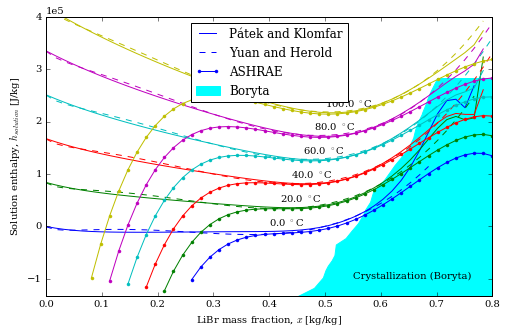

In [3]:
x = np.linspace(0,.8)
T_ref = 293.15
h_offset = libr_props.massSpecificEnthalpy(T_ref,x)
#fig = plt.figure(figsize=(16,8))
fig = plt.figure(figsize=(8,5),dpi=600)
plt.xlabel("LiBr mass fraction, $x$ [kg/kg]")
plt.ylabel("Solution enthalpy, $h_{{solution}}$ [J/kg]")
fig.gca().ticklabel_format(axis='y', style = 'sci', scilimits=(-2,2), useOffset=False)
def _crop(h):
    if h < -1.3e5 or h > 4e5:
        return np.nan
    return h
crop = np.vectorize(_crop)
TT = [273.15,293.15,313.15,333.15,353.15,373.15]
cc = 'b g r c m y'.split()

for T,c in zip(TT,cc):
    h0 = libr_props.massSpecificEnthalpy(T,x)
    #h1 = Hsat2(T,x)+h_offset
    h2 = hfun2(T,x)
    h4 = hfun4(T,x)
    plt.plot(x,crop(h0),color=c,label="Pátek and Klomfar" if T == 273.15 else None)
    #plt.plot(x,h1,'--',label="CoolProp")
    plt.plot(x,crop(h4),'--',color=c,label="Yuan and Herold" if T == 273.15 else None)
    plt.plot(x,crop(h2),'.-',color=c,label="ASHRAE" if T == 273.15 else None)
    xtext = 0.4 + (T-273.15) * 0.001
    htext = libr_props.massSpecificEnthalpy(T+5,xtext)
    plt.annotate('{} $^\circ$C'.format(T-273.15),[xtext,htext])
bottom = 0.8 + 0*libr_props.crystallization_data_T
h_crystal = hfun2(libr_props.crystallization_data_T+273.15,
                libr_props.crystallization_data_x)
plt.fill_betweenx(h_crystal,
                   libr_props.crystallization_data_x,
                   bottom,
                   edgecolor='aqua',
                   facecolor='aqua',
                   label="Boryta")
plt.annotate('Crystallization (Boryta)',[0.55,-1e5])    

plt.ylim([h_crystal.min(),4e5])
plt.xlim([0,0.8])
plt.legend(loc='upper center')
# For word, export svg and convert with inkscape
plt.savefig('../img/compare_libr_props.fig1.svg')

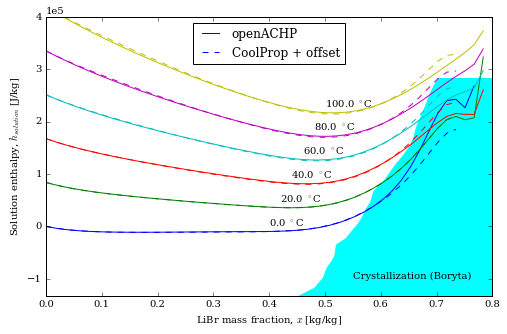

In [4]:
fig = plt.figure(figsize=(8,5),dpi=600)
plt.xlabel("LiBr mass fraction, $x$ [kg/kg]")
plt.ylabel("Solution enthalpy, $h_{{solution}}$ [J/kg]")
fig.gca().ticklabel_format(axis='y', style = 'sci', scilimits=(-2,2), useOffset=False)
def _crop(h):
    if h < -1.3e5 or h > 4e5:
        return np.nan
    return h
crop = np.vectorize(_crop)
TT = [273.15,293.15,313.15,333.15,353.15,373.15]
cc = 'b g r c m y'.split()
for T,c in zip(TT,cc):
    h0 = libr_props.massSpecificEnthalpy(T,x)
    h1 = Hsat2(T,x)+h_offset
    plt.plot(x,crop(h0),color=c,label="openACHP" if T == 273.15 else None)
    plt.plot(x,crop(h1),'--',color=c,label="CoolProp + offset" if T == 273.15 else None)
    xtext = 0.4 + (T-273.15) * 0.001
    htext = libr_props.massSpecificEnthalpy(T+5,xtext)
    plt.annotate('{} $^\circ$C'.format(T-273.15),[xtext,htext])

# Crystallization curve
bottom = 0.8 + 0*libr_props.crystallization_data_T
h_crystal = hfun2(libr_props.crystallization_data_T+273.15,
                libr_props.crystallization_data_x)
plt.fill_betweenx(h_crystal,
                   libr_props.crystallization_data_x,
                   bottom,
                   edgecolor='aqua',
                   facecolor='aqua')
plt.annotate('Crystallization (Boryta)',[0.55,-1e5])

plt.ylim([h_crystal.min(),4e5])
plt.xlim([0,0.8])
plt.legend(loc='upper center')
# For word, export svg and convert with inkscape
plt.savefig('../img/compare_libr_props.fig2.svg')

In [5]:
import libr3
chiller=libr3.ChillerLiBr1(T_evap=5,T_cond=45,x1=0.6026,x2=0.66)
#chiller=libr3.ChillerLiBr1(T_evap=5,T_cond=30,x1=0.5,x2=0.66)
chiller.iterate1()
chiller2=libr3.ChillerLiBr1(T_evap=5,T_cond=50,x1=0.627,x2=0.66)
chiller2.iterate1()
chiller3=libr3.ChillerLiBr1(T_evap=5,T_cond=55,x1=0.6515,x2=0.66)
chiller3.iterate1()
print chiller
print chiller3
def cyclexh(ch):
    cyclex = [ch.x1, ch.x1, ch.x2, ch.x2, ch.x1]
    cycleh = [ch.h_abs_outlet, ch.h_gen_inlet, ch.h_gen_outlet, ch.h_abs_inlet, ch.h_abs_outlet]
    return cyclex,cycleh

------------------------  ---------------  -----
T_evap                         5           C
T_cond                        45           C
P_evap                       872.575       Pa
P_cond                      9595           Pa
x1                             0.6026      kg/kg
x2                             0.66        kg/kg
T_gen_inlet                   91.6086      C
T_gen_outlet                 104.795       C
T_abs_inlet_max               56.7289      C
T_abs_outlet_max              45.0119      C
h_gen_inlet               218484           J/kg
h_gen_outlet              274075           J/kg
h_abs_inlet               189768           J/kg
h_abs_outlet              128996           J/kg
m_pump                         0.05        kg/s
m_concentrate                  0.0456515   kg/s
m_refrig                       0.00434848  kg/s
Eff_SHX                        0.64        K/K
T_SHX_concentrate_outlet      66.5337      C
Q_SHX                       3073.38        W
T_abs_pre         

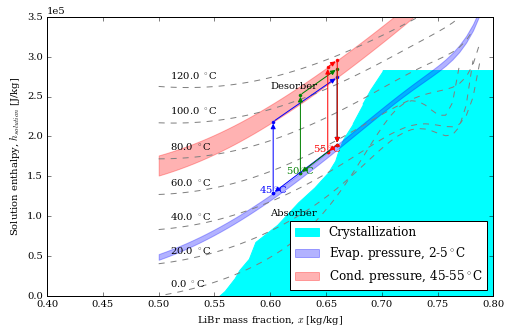

In [6]:
#fig = plt.figure(figsize=(8,5))
x=np.linspace(0.5,0.8)
fix, ax = plt.subplots(1, figsize=(8,5))
plt.xlabel("LiBr mass fraction, $x$ [kg/kg]")
plt.ylabel("Solution enthalpy, $h_{{solution}}$ [J/kg]")
ax.ticklabel_format(axis='y', style = 'sci', scilimits=(-2,2), useOffset=False)
def _crop(h):
    if h < 0 or h > 3.5e5:
        return np.nan
    return h
crop = np.vectorize(_crop)
TT = [273.15,293.15,313.15,333.15,353.15,373.15,393.15]
cc = 'b g r c m y b'.split()
for T in TT:
    h0 = libr_props.massSpecificEnthalpy(T,x)
    h1 = Hsat2(T,x)+h_offset
    ax.plot(x,crop(h0),'--',color='gray')
    xtext = 0.51
    htext = libr_props.massSpecificEnthalpy(T+5,xtext)
    ax.annotate('{} $^\circ$C'.format(T-273.15),[xtext,htext])

# Crystallization curve
bottom = 0.8 + 0*libr_props.crystallization_data_T
h_crystal = hfun2(libr_props.crystallization_data_T+273.15,
                libr_props.crystallization_data_x)
ax.fill_betweenx(h_crystal,
                   libr_props.crystallization_data_x,
                   bottom,
                   edgecolor='aqua',
                   facecolor='aqua',
                   label="Crystallization")
#ax.annotate('Crystallization (Boryta)',[0.55,-1e5])

# Corresponds to 1 to 5 C
Trange = 2,5
Prange = [CP.PropsSI("P","T",t+273.15,"Q",0,"HEOS::water") for t in Trange]
hrange = [Hsat4(p,x) for p in Prange]
ax.fill_between(x,hrange[0],hrange[1],color='blue',alpha=0.3,
                label="Evap. pressure, {}-{}$^\circ$C".format(*Trange))
# Corresponds to 45 to 55 C
Trange = 45,55
Prange = [CP.PropsSI("P","T",t+273.15,"Q",0,"HEOS::water") for t in Trange]
hrange = [Hsat4(p,x) for p in Prange]
ax.fill_between(x,hrange[0],hrange[1],color='red',alpha=0.3,
                label="Cond. pressure, {}-{}$^\circ$C".format(*Trange))

for ch,c in zip([chiller,chiller2,chiller3],['b','g','r']):
    cyclex,cycleh = cyclexh(ch)
    ax.plot(cyclex,cycleh,'.',color=c)
    for i in range(4):
        ax.annotate("",(cyclex[i+1],cycleh[i+1]),(cyclex[i],cycleh[i]),
                    arrowprops=dict(arrowstyle="-|>",facecolor=c,edgecolor=c))
    ax.annotate("{}$^\circ$C".format(ch.T_cond),(ch.x1-0.013,ch.h_abs_outlet),color=c)
ax.annotate('Absorber',(0.6,1e5))
ax.annotate('Desorber',(0.6,2.6e5))

plt.ylim([0,3.5e5])
plt.xlim([0.4,0.8])
ax.legend(loc='lower right')
# For word, export svg and convert with inkscape
plt.savefig('../img/compare_libr_props.fig3.svg')
plt.show()

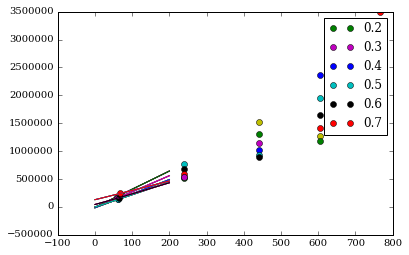

In [7]:
# Now compare enthalpies of subcooled states.
plt.figure()
for x in [0.2,0.3,0.4,0.5,0.6,0.7]:
    first = True
    for P in [300,600,1200,1800,2400]: # Pa
        Tsat = t_ssc(P,x)
        hsat = hfun3(Tsat,x,P)
        T = np.linspace(273,473)

        h=hfun4(T,x,P)

        plt.plot(T-273.15,h)
        plt.plot(Tsat-273.15,hsat,'o',label=str(x) if first else None)
        first = False
plt.legend()
plt.show()

In [8]:
for name in SSC_DLL.getDLFnames():
    f = SSC_DLL.func[name]
    print name, f.getCallFormat()[0], f.getInputUnits(), "|->", f.getOutputUnits()
print h_librssc.getCallFormat()
print h_librssc.getInputUnits()
s,outargs=h_librssc.call("",[20,x])
print "Text: '{}'".format(s.strip())
print "Numbers: ", outargs

s,outargs=h_librssc.call("",[20,x,9,9,9])
print "Text: '{}'".format(s.strip())
print "Numbers: ", outargs

s,outargs=h_librssc.call("",[20,x,P*1e-3])
print "Text: '{}'".format(s.strip())
print "Numbers: ", outargs


LiBrSSCCond k = LiBrSSCCond(Tc,X) ['C', '-'] |-> ['W/m-K']
LiBrSSCVisc mu = LiBrSSCVisc(Tc,X) ['C', '-'] |-> ['cP']
LiBrSSCCp cp = LiBrSSCCp(Tc,X,P) or cp_sat = LiBrSSCCp(Tc,X) ['C', '-', 'kPa'] |-> ['J/g-K']
LiBrSSCT T_sat = LiBrSSCT(P,X) ['kPa', '-'] |-> ['C']
LiBrSSCX X_sat = LiBrSSCX(T, P) ['C', 'kPa'] |-> ['-']
LiBrSSCh h = LiBrSSCh(Tc,X,P) or h_sat = LiBrSSCh(Tc,X)  ['C', '-', 'kPa'] |-> ['J/g']
LiBrSSCuw mu_w = LiBrSSCuw(Tc,X, P) ['C', '-', 'kPa'] |-> ['J/g']
LiBrSSCus mu_libr = LiBrSSCus(Tc,X, P) ['C', '-', 'kPa'] |-> ['J/g']
LiBrSSCv v = LiBrSSCv(Tc,X) ['C', '-'] |-> ['m^3/kg']
LiBrSSCs s = LiBrSSCs(Tc,X,P) or s_sat = LiBrSSCs(Tc,X) ['C', '-', 'kPa'] |-> ['J/g-K']
LiBrSSCp P_sat = LiBrSSCp(Tc,X) ['C', '-'] |-> ['kPa']
LiBrSSCTCryst T_cryst = LiBrSSCTCryst(X) ['-'] |-> ['C']
LiBrSSCRefIndex N = LiBrSSCRefIndex(Tc,X) ['C', '-'] |-> ['-']
('h = LiBrSSCh(Tc,X,P) or h_sat = LiBrSSCh(Tc,X) ', ['Tc', 'X', 'P'])
['C', '-', 'kPa']
Text: ''
Numbers:  162.139249989
Text: 'LiBrSSCh expect

In [29]:
Hsat4(300,x)

array([None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None, None, None,
       None, None, None, None, -41820.38954497315, -37152.18172337598,
       -32352.857335884182, -27431.886747314973, -22400.670663763973,
       -17272.926097884105, -12065.140942921425, -6797.077675056033,
       -1492.3029971176002, 3821.282554180885, 9110.942809620174,
       14338.660674075014, 19460.778177385626, 24427.750401367957,
       29184.04135129819, 33668.189711834624, 37813.07313462658,
       41546.40191532056, 44791.47731418873, 47468.25720822984, None, None,
       None, None], dtype=object)

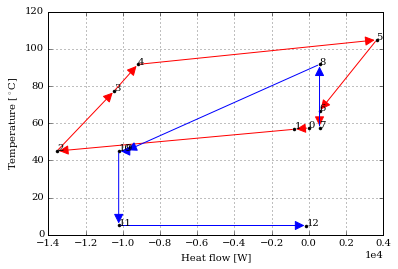

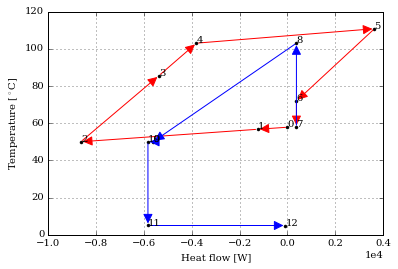

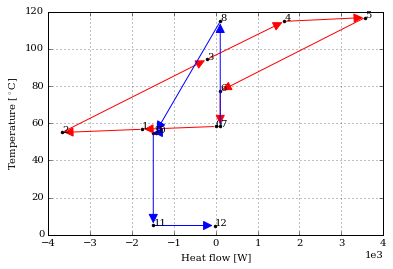

In [9]:
for ch,c in zip([chiller,chiller2,chiller3],['b','g','r']):
    Q,T = ch.getHeatCurve()
    plt.plot(Q[0:7],T[0:7],'k.')
    plt.plot(Q[7:],T[7:],'k.')
    plt.xlabel('Heat flow [W]')
    plt.ylabel('Temperature [$^\circ$C]')
    for i in range(len(Q)-1):
        plt.annotate("",(Q[i+1],T[i+1]),(Q[i],T[i]),
            arrowprops=dict(arrowstyle="-|>",color='r' if i < 7 else 'b'),
            size=20)
        plt.annotate(i,(Q[i],T[i]))
    i += 1
    plt.annotate(i,(Q[i],T[i]))
    plt.gca().ticklabel_format(style='sci',scilimits=(-2,3),axis='both')
    plt.grid(True)
    #plt.xlim([-1.4e4,0.4e4])
    #plt.savefig("../img/heat_curve{}.svg".format(c))
    plt.show()

In [20]:
Q[0:7]

[0,
 -1761.6320365384879,
 -3675.1067045360505,
 -212.14144520996706,
 1637.9627652916224,
 3570.3768768425871,
 107.82344713173734]

1400.73723449 12839.5312357 14240.2684702
0.66 77.2525759441 104.794755474


(0, 1000)

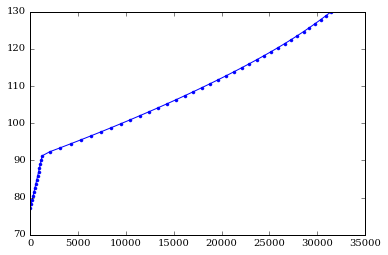

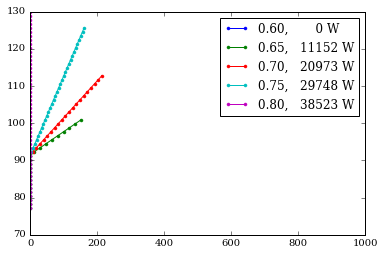

In [10]:
ch = chiller
print ch.Q_gen_pre_heat, ch.Q_gen_main, ch.Q_gen_total
x_out = ch.x2
print x_out, ch.T_gen_pre, ch.T_gen_outlet
ch.buildGeneratorHeatCurve()
T = np.linspace(ch.T_gen_pre, 130)
x = 0.8
q,Q = np.vectorize(ch.generatorHeatCurveQ)(T,0.8)
q_baseline,Q_baseline = q,Q
plt.plot(q[q<Q],T[q<Q],'.-')
plt.figure()
for x in np.linspace(ch.x1,0.8,5):
    q,Q=np.vectorize(ch.generatorHeatCurveQ)(T,x)
    dq=q-q_baseline
    plt.plot(dq[q<Q],T[q<Q],'.-',label="{:0.2f},{:>8.0f} W".format(x,Q[0]))
plt.legend(loc='best')
plt.xlim([0,1000])

In [10]:
np.linspace(0,5,6)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [21]:
(T>115).nonzero()

(array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)

In [24]:
q_baseline[36:49]

array([ 22903.89329366,  23677.21829788,  41778.63507899,  41654.47631984,
        41531.1564812 ,  41408.30455484,  27265.0275647 ,  27922.61010456,
        28559.64024507,  29176.50421855,  29773.99520886,  30353.3352691 ,
        30916.18634857])

In [25]:
T[38], T[41]

(118.15874153847957, 121.38817566434878)

In [31]:
print libr_props.temperature(ch.P_cond * 1e-5,ch.x1) - 273.15
print libr_props.temperature(ch.P_cond * 1e-5,ch.x2) - 273.15

91.6086387132
104.794755474


In [43]:
for T in range(110,130):
    x = libr_props.massFraction(T+273.15,ch.P_cond*1e-5,(0.5,))
    h = libr_props.massSpecificEnthalpy(T+273.15,x)
    print T,x,h

110 0.681821289906 297221.421379
111 0.685938282154 301688.739457
112 0.69002658859 306155.303311
113 0.69408372299 310617.620089
114 0.698106756857 315071.898285
115 0.702092247089 319514.01845
116 0.706036180497 323939.53655
117 0.709933950084 328343.734347
118 0.713780379662 332721.730572
119 0.717569812733 337068.662929
120 0.721296277211 341379.943693
121 0.724953729058 345651.580903
122

 0.728536365823 349880.544768
123 0.732038987789 354065.148084
124 0.735457374409 358205.404948
125 0.738788637407 362303.33437
126 0.742031519939 366363.191618
127 0.745186621348 370391.62932
128 0.748256549884 374397.81858
129 0.751246027091 378393.586607
